*To run cells with code, `shift + enter`* 

*To restart the session, `Kernel -> Restart and clear output`*

# Dihedral Kullback-Leibler (KL) divergence
----

----
## Introduction 

-------



### <span style="color:DarkRed"> Some details on trajectory/topology input
    


-------

#### Simulation input

To run these scripts, you should have two (or more) different trajectories for the same protein, with different effectors bound. In these examples, the simulations have different allosteric ligands. 



#### Topology

It is useful that the data is first processed to ensure the same residues are present. This script will calculate psi/phi/chi in the order which they are in the topology, and assign using the index of the C$\alpha$ atom for that torsion.  Therefore having topology with the same atom indices ensures that for each system the output is the same. 


#### Trajectory 

All of these scripts will take input trajectories which are accepted by **[mdtraj](http://mdtraj.org/1.9.0/load_functions.html "mdtraj.Trajectory")**.

There are some basic scripts in the folder **`Scripts/Traj_processing_scripts`** for processing trajectory and topology using parmed or cpptraj. Remove any protein residues not common to both trajectory and also you can remove water as it will not be needed. 

As long as you have the same sequence of residues for the protein in each case, there is no need to remove any substrate,  ligand or ions, but it is useful to do also this now if you are also going to carry out a PCA. 



####  Kullback-Leibler divergence (KL)

Usually for each KL calculation, two different simulations are compared. These could be a simulation with no ligand bound and one with a ligand. Or two simulations with different ligands (i.e. activating or inhibiting ligands). 

Also in the scripts folder is a script to create two smaller trajectory from one larger one. It is useful to calculate the KL divergence of one system relative to itself, using two different (or one separated) trajectories, in order to take account of noise. 

----


### <span style="color:DarkRed"> Kullback-Leibler (KL) Divergence 

---
**KL divergence is defined as:**

\begin{equation}
D_{KL} (P\|Q)=\sum _{i}P(i)\,\log {\frac {P(i)}{Q(i)}}
\end{equation}

In this case, distribution P will be the data obtained from one simulation *(i.e. protein with activator bound)* and distribution Q will be that obtained from another simulation *(i.e. protein with inhibitor bound)*. This is computed over a range of *i* bins.

**P** and **Q** refer to distributions of a particular descriptor, for example a particular Psi angle, and we can collect the value of that Psi angle as a distribution over the trajectory. 

So for the activator bound simulation we could obtain the distibution in green for **P**, and for the inhibitor bound simulation we obtain the distribution in blue for **Q**. 

* In the first case, the distributions are similar, and so the mean value will be similar, and the KL divergence will be small. 


* In the second case, the mean value is similar, but the KL divergence will be higher since the distributions are not the same across all bins. 


* In the third case, the mean value is different and the KL divergence is higher. 



<img src="z_images/distributions.png">

-----------


# <span style="color:DarkRed"> Overall workflow

-----------

To summarise the overall workflow:

1. Run simulations. 

2. Calculate distributions of torsions. 

3. Compute KL between the different systems. 

4. Input KL as a B-factor into the pdb to visualise.


<img src="z_images/KL_calculation.png" width="800" >

---
##### Some notes on the workflow: 

* Step 1 of the workflow: Run simulations and process the trajectories to ensure you have identical topology / order of residues.


* Step 2 of the workflow: The first script calculates distributions of Psi, Phi, Chi1 and Chi2 from a trajectory. These distributions are output as a text file for each torsion, into folders PSI, PHI, CHI1, CHI2 in the directory OUTPUT. In step 2 we also have to assign each torsion to the correct residue.


* Step 3 of the workflow: KL values are then calculated with another script which just loops through the files output by the first script, and these KL values can then be input onto the structure to highlight the high KL regions, for Psi, Phi, Chi1 and Chi2 separately; or grouped as either backbone or sidechain. 


* Step 4 of the workflow: A pymol script will load the output from the KL calculation to be visualised on the structure.



-------

# <span style="color:teal"> Step 1 of the workflow: </span>

--------

### 1.1 Folder and filenames

-------

#### *<span style="color:red">The folders for trajectories are already set up for the tutorial: so there is no need to do anything for section 1.1. For info only.</span> *


To run on other systems set up the following folder structure to complete the analysis.

**`mkdir 0_Analysis`**  

Then set up a folder for trajectory data.

**`cd 0_Analysis
mkdir 0_TRAJECTORIES`**

Within 0_TRAJECTORIES make a folder for each system, and inside these folders either put the trajectory and topology files, or soft links to them. Also include a pdb file with the same topology as the trajectory (usually just take the first frame of the simulation).

**`cd 0_TRAJECTORIES
mkdir 0_system_A
mkdir 1_system_B`**

**`cd 0_system_A
ln -s /home/somefilelocation/traj0001.dcd
ln -s /home/somefilelocation/topology.parm7
ln -s /home/somefilelocation/first_frame.pdb`**

Within each you can have one or more trajectories. For example, if you have a long trajectory which was run in segments, or if you want to use many different runs of the same system in order to use more snapshots, just input these separately in "filename_list":

*e.g.* 
*filename_list_system_A = ["traj1.dcd" , "traj2.dcd" , "traj3.dcd" , "traj4.dcd" , "traj5.dcd"]*

<span style="color:red"> *(We plan to change this in order just to automatically pull all files with a particular extention (e.g. .dcd) into these lists: but for now they have to be input)*</span>


### 1.2 Simulations for this tutorial
------


For this example, two systems are used: 

**0_system_A**  (*PDK1 with allosteric inhibitor 1F8 bound. PDB ID [3ORX](https://www.rcsb.org/structure/3ORX)*)

**1_system_B**  (*PDK1 with allosteric activator 2A2 bound. PDB ID [3ORZ](https://www.rcsb.org/structure/3orz).*)

And within each of these folders are two trajectory files (in .dcd format) along with the topology file (in .parm7 format). 

traj0001.dcd and traj0002.dcd are both 500 ns sections of the same simulation which have been post processed to remove everything other than the protein (NME and ACE caps removed, water, ligand, ATP, Mg2+ ions and substrate peptide are present in the original simulation but removed for analysis). As long as you remove any different residues, there isn't really a need to remove some of these, but easier to have less unneccessary data to process. 

Ideally have a tracectory with many frames (save a snapshot around every 10 ps or so). 

The trajectories included here initially have 100k snapshots for 500 ns simulation, but have been reduced to 2000 snapshots per 500 ns for the purpose of the tutorial. 

-----

Check we are in the correct folder `0_Analysis`:

Run the below cell with `shift + enter` : 

In [1]:
pwd

u'/home/t702348/lisa/X_PDK1_tutorial/0_Analysis'

Check that filenames within each folder are correctly set up.

We will need the files `topology.parm7` , `traj0001.dcd` and `traj0002.dcd` for this tutorial. 

`first_frame.pdb` will be used to visualise results.

In [2]:
ls 0_TRAJECTORIES/0_system_A/

cap_traj/        longtraj_aligned_PCA.dcd  topology.parm7
cpptraj.log      parmed.log                traj0001.dcd
first_frame.pdb  short_traj_aligned.dcd    traj0002.dcd


In [3]:
ls 0_TRAJECTORIES/1_system_B/

cap_traj/        longtraj_aligned_PCA.dcd  topology.parm7
cpptraj.log      parmed.log                traj0001.dcd
first_frame.pdb  short_traj_aligned.dcd    traj0002.dcd



---

# <span style="color:teal"> Step 2 of the workflow: </span>

----


### Import required packages

The following packages are required. 

You can run the below cell with `shift + enter` : 

In [4]:
import scipy as sp
import numpy as np
import mdtraj as md
import sys
import os
import math

# And need this to show plots etc in jupyter notebook
get_ipython().magic(u'pylab inline')

Populating the interactive namespace from numpy and matplotlib


----
### 2.0.  Calculate dihedral distributions

There are 2 arguments that have to be passed with the script. 

- **Input system**

Select the system to run using `input_system`.

`input_system` is a list at the start of the script `1_dihedral_for_tutorial.py`. 

It just contains the names of the folders for the different systems:

`system_list = ["0_system_A","1_system_B"]`

Select using the index of the list (0 for the first entry in the list, 1 for the second).

- **Number of bins **

The number of bins will depend on the number of snapshots used. 

For a simulation of 1 $\mu$s, usually we save around 200k snapshots. Around 300 bins is appropriate for this number of datapoints. 

In this example, we have 4000 snapshots and so 60 bins are used.

#### Run the script:

Run as `$ python 1_dihedral_for_tutorial.py *input_system* *number_of_bins*`

So for the first system: `$ python 1_dihedral_for_tutorial.py 0 60`

To run from the notebook, execute the cell below with `shift + enter`:

In [5]:
!python Scripts/1_dihedral_for_tutorial.py 0 60

2.1: input system is: 0_system_A
MD data located in directory: 0_TRAJECTORIES
Topology filename is: topology.parm7
Trajectories are ['traj0001.dcd', 'traj0002.dcd']

2.2: list of all input file locations.
[['0_TRAJECTORIES/0_system_A/traj0001.dcd', '0_TRAJECTORIES/0_system_A/traj0002.dcd'], ['0_TRAJECTORIES/1_system_B/traj0001.dcd', '0_TRAJECTORIES/1_system_B/traj0002.dcd']]

2.3: Creating output folders for all systems
Folder created for 1_DIHEDRALS/0_system_A/OUTPUT/PSI
Folder created for 1_DIHEDRALS/1_system_B/OUTPUT/PSI
Folder created for 1_DIHEDRALS/0_system_A/OUTPUT/PHI
Folder created for 1_DIHEDRALS/1_system_B/OUTPUT/PHI
Folder created for 1_DIHEDRALS/0_system_A/OUTPUT/CHI1
Folder created for 1_DIHEDRALS/1_system_B/OUTPUT/CHI1
Folder created for 1_DIHEDRALS/0_system_A/OUTPUT/CHI2
Folder created for 1_DIHEDRALS/1_system_B/OUTPUT/CHI2

2.4: Loading trajectory and calculating for system: 

0_system_A

One trajectory file traj0001.dcd is: 
<mdtraj.Trajectory with 2000 frames, 4676 a

-----

-----

### <span style='color:DarkRed'>Details on what is calculated with the script: 

**Sections 2.1 to 2.7**: Details on the steps completed with the above script, and what you should expect to see printed when the cell above has run. 

### <span style='color:DarkRed'>To move onto the next step: 

**Section 2.8**: After running the script for 0_system_A, the next step will be to run for the second system.

**Step 3 of the workflow**: Once both systems have been run, we will do the KL-divergence calculation. 

-----

-----


### 2.1. Selecting input and setting trajectory/topology filenames

Set up `system_list` with folder names of different systems. This can be 2 or more different systems:

- e.g. `system_list = ["0_system_A","1_system_B"]`

Input one or more trajectory names into `filname_list`: 

- e.g. `filename_list = ["traj0001.dcd","traj0002.dcd"]`

Input topology filename: 

- e.g. `topology_filename = "topology.parm7"`

Input location of MD data: 

- e.g. `md_data = ["0_TRAJECTORIES"]`

### 2.2. Make lists of directories to trajectory data 
---

Based on the info given above, the script will create lists of file locations for trajectories. 

The script shoud print a table with the locations of all trajectory files. 
It should also print which system you are currently calculating. 



### 2.3. Create folders for the output files
---

Folders for the system being run should be created for the output distributions to be stored: 

`1_DIHEDRALS/0_system_A/OUTPUT/PSI`

`1_DIHEDRALS/0_system_A/OUTPUT/PHI`

`1_DIHEDRALS/0_system_A/OUTPUT/CHI1`

`1_DIHEDRALS/0_system_A/OUTPUT/CHI2`

### 2.4. Load the trajectory
---


We are loading two parts to the trajectory: `traj0001.dcd` and `traj0002.dcd`. The script should print the frames being loaded. 

#### *Here you can save the first frame as a pdb*

For the tutorial, in order to load the results in pymol, there is already a pdb for each in the 0_TRAJECTORIES folder. 

If you don't already have a pdb, there is a line (as below) in the script which is commented out, which would save a pdb to the folder `0_TRAJECTORIES/*selected_system*`

`traj[0].save_pdb("%s/%s/first_frame.pdb" % (md_data[0],system_list[input_system]))`

### 2.5. Compute dihedrals
---

#### Torsions calculated 

We use **[mdtraj](http://mdtraj.org/1.9.0/api/generated/mdtraj.compute_psi.html "mdtraj.compute_psi")** to compute the dihedrals. We have only included Psi and Phi for the backbone, and Chi1 and Chi2 for the sidechain torsions at this stage. However **mdtraj** can compute Psi, Phi, Omega, Chi1, Chi2, Chi3 and Chi4 so this could be extended. 

A file will be saved which states how many psi, phi, chi1 and chi2 there are for the system.

---
md.compute_psi gives an output of this format:

**psi_list[0]** gives the *atom indices* making up each psi torsion.

**psi_list[1]** gives the *value of psi* for each residue, for *each snapshot*.

---

---

---

> #### <span style="color:Purple">Memory issues:
> We loaded the whole trajectory to memory with `md.load_dcd` by loading traj0001.dcd and traj0002.dcd and joining them together; however this may not always be possible if you have limited memory, or a very large trajectory. 

> You can also use **[md.iterload](http://mdtraj.org/1.9.0/api/generated/mdtraj.iterload.html "mdtraj.iterload")** instead of initally loading the entire trajectory to memory. This would be done as follows:

> #### Make lists to collect torsions: 

> `psi_list = []`
> `phi_list = []`
> `chi1_list = []`
> `chi2_list = []`

> #### Use `md.iterload` to calculate torsions and append them to each list:

> `for chunk in md.iterload(trajfile, chunk=100, top=top):
	psi_list.append(md.compute_psi(chunk,periodic=True,opt=True))
	phi_list.append(md.compute_phi(chunk,periodic=True,opt=True))
	chi1_list.append(md.compute_chi1(chunk,periodic=True,opt=True))
	chi2_list.append(md.compute_chi2(chunk,periodic=True,opt=True))`    
    

> #### NB: With `iterload`, the output is slightly different to `md.load`

> Further scripts will be set up to run this with iterload. 

---

---




### 2.6. Outputting a file with CA indexes for each psi, phi, chi1 and chi2

---


The rest of this script saves each torsional angle numbered Psi(0) to Psi(n), Chi1(0) to Chi1(m), etc, and not per residue: so we need to match up which atom indexes match to which Psi, Phi, Chi1 & Chi2. 

The script saves a file called `DIHEDRALS_CA_angles_indexes.dat` with: 

    
| CA index | PSI | PHI | CHI1 | CHI2 |
| :--- | :-: | :-: | :--: | :--: |
| 2 |  0 | none | 0 | 0 | 
| 26 | 1 | 0 | 1 | 1 | 
| 48 | 2 | 1 | 2 | 2 | 
| 70 | 3 | 2 | 3 | 3 | 


Where the first column are the C$\alpha$ indexes and then which Psi Phi Chi1 Chi2 should be assigned to that C$\alpha$. Not all cases have Chi1 and Chi2 and so for those C$\alpha$ they will show "none". 

We will run the script for each system, saving this file to the folder associated with that system in order to later check that the atom indices that we are calculating are the same for each torsion computed. 

After you have run Step 2 of the workflow for both systems, you can use vimdiff on the file output for each case: 

`$ vimdiff 1_DIHEDRALS/0_system_A/DIHEDRALS_CA_angles_indexes.dat 1_DIHEDRALS/1_system_B/DIHEDRALS_CA_angles_indexes.dat`

### 2.7. Computing distributions of dihedrals
---

From the md.compute_psi, we have an list which is *DIHEDRAL* vs *SNAPSHOT*. We need to calculate for every dihedral a probability distribution. 

Also when calculating KL, **both distributions should be continuous**. That is, if P(i)=0 or Q(i)=0 then there is no solution. In order to avoid this problem, a negligibly small value is added to any zero-count bins. 

The script should print which torsions are being calculated and print the location which files are being saved. 

Files are saved for each torsion, as a histogram, and as the raw data (i.e. the value per snapshot for that torsion) as follows: 



`1_DIHEDRALS/0_system_A/OUTPUT/PSI/psi_hist_92.dat`

`1_DIHEDRALS/0_system_A/OUTPUT/PSI/raw_data_psi_92.dat`

#### Torsion number and atom index

In order to keep track of which torsional distribution relates to which atoms, a file is output with the torsion number and the atom indices for that torsion.

`1_DIHEDRALS/0_system_A/OUTPUT/PSI/1_psi_indices_list.dat`

### 2.8. Compute the same for the second system.
----------

We can just change the number passed with the script from *0* to *1*, to select the second system, as below: 

In [6]:
!python Scripts/1_dihedral_for_tutorial.py 1 60

2.1: input system is: 1_system_B
MD data located in directory: 0_TRAJECTORIES
Topology filename is: topology.parm7
Trajectories are ['traj0001.dcd', 'traj0002.dcd']

2.2: list of all input file locations.
[['0_TRAJECTORIES/0_system_A/traj0001.dcd', '0_TRAJECTORIES/0_system_A/traj0002.dcd'], ['0_TRAJECTORIES/1_system_B/traj0001.dcd', '0_TRAJECTORIES/1_system_B/traj0002.dcd']]

2.3: Creating output folders for all systems

2.4: Loading trajectory and calculating for system: 

1_system_B

One trajectory file traj0001.dcd is: 
<mdtraj.Trajectory with 2000 frames, 4676 atoms, 285 residues, and unitcells>
Combined traj0001.dcd and traj0002.dcd is: 
<mdtraj.Trajectory with 4000 frames, 4676 atoms, 285 residues, and unitcells>

2.5: Computing Dihedrals
computing psi
computing phi
computing chi1
computing chi2
The system has the following numbers of psi, phi, chi1 and chi2: 
[['Number of psi' '284']
 ['Number of phi' '284']
 ['Number of chi1' '252']
 ['Number of chi2' '204']]
Saving number of a



----------

### 2.9. If you have now run both system A and B: move on to Step 3 of the workflow below 

-----------

-----------

-----------

> #### <span style="color:Purple">To run as a script for several systems: </span>
> To run this for several systems, use the bash script `Scripts/1_dihedral_many_systems.sh` with `Scripts/1_dihedral.py`. 

> First alter `1_dihedral.py`: system_list, filename_list, topology_filename and md_data.

> Then run `1_dihedral_many_systems.sh` with 2 arguments: 
   
>    * The number of systems given in `system_list`.
>    * The number of bins to histogram the data. 


-----------


----

# <span style="color:teal"> Step 3 of the workflow: </span>

---

### Calculating KL between two systems 

A bash script will now loop thorugh all of the output files for the two systems which we created with 1_Dihedral.py and calculate the KL value. 

We run this script with several arguments. In the next cell, we print `number_angles_array` which gives how many psi, phi, chi1 and chi2 there are in the system. There is a file saved in the folder 1_DIHEDRALS/**number_angles.dat** with this information.

--- 

----

> #### <span style="color:Purple">To run the script in terminal instead of in the notebook: </span>

> ` $ bash 2_run_all_KL.sh`  `systemA_folder_name`  `systemB_folder_name`  `number_psi_angles`  `number_phi_angles`  `number_chi1_angles`  `number_chi2_angles`

> e.g. `bash ../Scripts/2_run_all_KL.sh 0_system_A 1_system_B 284 284 252 204` 

<br><br>

### 3.1. Print the number of angles for each torsion
---

In [7]:
cat 1_DIHEDRALS/number_angles.dat

Number of psi 284
Number of phi 284
Number of chi1 252
Number of chi2 204



### 3.2. Run the bash script to calculate the KL between the two systems 
---
First, change directory to 1_DIHEDRALS as all output will be processed and saved in this folder.

Move to the folder `1_DIHEDRALS` :

In [8]:
cd 1_DIHEDRALS

/home/t702348/lisa/X_PDK1_tutorial/0_Analysis/1_DIHEDRALS


In [9]:
# This may take a few minutes!
!bash ../Scripts/2_run_all_KL.sh 0_system_A 1_system_B 284 284 252 204

psi KL calculating ...
phi KL calculating ...
chi1 KL calculating ...
chi2 KL calculating ...
Time in seconds to run KL script:  
512


### 3.3.  Collect KL values and assign them to the correct residue
---

For the first script, we saved a file with the C$\alpha$ index and the torsion number, to later assign each KL value to the correct residue. 

To do this, the script `Scripts/5_combining_psi_phi_chi.py` is used, and can be run from the cells below. This should be run from the folder `1_DIHEDRALS`. 

This will output a file with the number of the residue in the first column, the number of the C$\alpha$ atom in the second column, and the remaining 4 columns are the KL value for the Psi, Phi, Chi1 and Chi2 torsions respectively. 

From 2.6, we should already have the file
`DIHEDRALS_CA_angles_indexes.dat`, which looks like this:

| CA index | PSI | PHI | CHI1 | CHI2 |
| :--- | :-: | :-: | :--: | :--: |
| 2 |  0 | none | 0 | 0 | 
| 26 | 1 | 0 | 1 | 1 | 
| 48 | 2 | 1 | 2 | 2 | 
| 70 | 3 | 2 | 3 | 3 | 

<br><br>

And then running `Scripts/5_combining_psi_phi_chi.py` will output 
`KL_residue_caindex_psi_phi_chi_chi.dat`, which looks like this: 

|Residue number | CA index | PSI KL | PHI KL | CHI1 KL | CHI2 KL |
| :--- | :-: | :-: | :--: | :--: |:--: |
| 1 | 2 | 0.013591 | 0.000000 | 0.014678 | 0.036920 | 
| 2 | 26 | 0.011217 | 0.030264 | 0.022233 | 0.012993 | 
| 3 | 48 | 0.077490 | 0.010198 | 0.067854 | 0.056849 | 
| 4 | 70 | 0.023213 | 0.007356 | 0.198231 | 0.125124 | 


Where KL values for each torsion is listed per residue, and a value of zero is assigned if that residue does not have a particular torsion associated with it. 
<br><br>

**This script also outputs several other files:**

Each is a list of the KL of that torsion, for each residue. 

* KL_psi.dat

* KL_phi.dat

* KL_chi1.dat

* KL_chi2.dat


Also a file which sums the KL for *Phi+Psi* as "backbone"; and *Chi1+Chi2* as "sidechain".

* KL_backbone.dat

* KL_sidechain.dat


> #### <span style="color:Purple">To run the script in terminal instead of in the notebook: </span>

> `python script.py KL-output-directory`

> <span style="color:LightSlateGray"> e.g.</span>

> `python 5_combining_psi_phi_chi.py KL_OUTPUT/0_system_A_1_system_B`

---

As mentioned before, it is sensible to check that the output from the two systems is the same (to check for any errors with different topology, for example). 

`$ vimdiff 1_DIHEDRALS/0_system_A/DIHEDRALS_CA_angles_indexes.dat 1_DIHEDRALS/1_system_B/DIHEDRALS_CA_angles_indexes.dat`

If they are identical, copy one of these to the folder 1_DIHEDRALS:

In [10]:
pwd

u'/home/t702348/lisa/X_PDK1_tutorial/0_Analysis/1_DIHEDRALS'

In [11]:
cp 0_system_A/DIHEDRALS_CA_angles_indexes.dat .




------

The KL calculation will have output values in a folder named: `1_DIHEDRALS/KL_OUTPUT/0_system_A_1_system_B`

To combine all the KL values, run the script in the cell below, `5_combining_psi_phi_chi.py`, with one argument which is the folder containing the KL output. 

---


In [12]:
!python ../Scripts/5_combining_psi_phi_chi.py KL_OUTPUT/0_system_A_1_system_B


So now we have a file with the residue number, the CA index and the corresponding KL values for each torsion; and other files where we group together the KL for the backbone torsions and the sidechain torsions separately. 

---

# <span style="color:teal"> Step 4 of the workflow: </span>

---

### Visualising the output of the KL calculation 



Normally we visualise the KL caldulation by inputting these backbone and sidechain KL values into the b-factor column of a pdb, which can then be colour coded in pymol to show the high-KL regions. 

Plotting the KL values of sidechain and backbone against the residue number (below), shows that the higher values for the backbone and sidechain tend to be for different residues. So it is useful to plot in pymol the sidechain and backbone separately. 

---



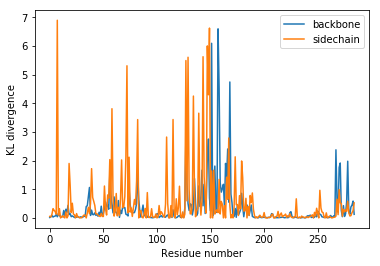

In [13]:
backbone = np.loadtxt("KL_backbone.dat")
sidechain = np.loadtxt("KL_sidechain.dat")

plt.plot(backbone,label="backbone")
plt.plot(sidechain,label="sidechain")
plt.xlabel("Residue number")
plt.ylabel("KL divergence")
plt.legend()


### 4.1 Loading the KL values into a pymol session
---

In the cell below, launch a pymol session and run the pymol script `../Scripts/6_pymol_all_dihed.pml`


In [ ]:
!pymol ../Scripts/6_pymol_all_dihed.pml



This should launch a pymol session, loading the pdb structure from one system, and creating a few separate objects: One with the KL for the backbone torsions and another for the KL for the sidechain. Then separately for Psi, Phi, Chi1 and Chi2.

These are colour scaled individually: Since high KL values for each case may not be similar size it can be useful to look at them separately. If you want to scale the colour plot to the same values for both backbone and sidechain, this can be done by altering pymol_all_dihed.pml (there is a section commented out that can be changed on line 30). 

---

A pymol session is then saved as **"Dihedral_KL.pse"**.

The output should look similar to below. 

On the right, you can switch between backbone, sidechain, or individual torsions. 

Colour scale is: 

<img src="z_images/KL_colour_scale.png" width="500">

<img src="z_images/pymol_session_Dihedrals.png">